In [ ]:
 # Importing necessary libraries
import os
import numpy as np
import pandas as pd
import shutil
import cv2
import random
import matplotlib.pyplot as plt
import copy

Defining some variables which will be needed later

In [ ]:
bs=' ' # blank-space
class_id=0 # id for face
newline='\n' # new line character
extension='.txt' # extension for text file

In [ ]:
# Creating paths for separate images and labels
curr_path=os.getcwd()
imgtrainpath = os.path.join(curr_path,'images','train')
imgvalpath=os.path.join(curr_path,'images','validation')
imgtestpath=os.path.join(curr_path,'images','test')

labeltrainpath=os.path.join(curr_path,'labels','train')
labelvalpath=os.path.join(curr_path,'labels','validation')
labeltestpath=os.path.join(curr_path,'labels','test')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Defining data path and labels_path
data_path='/content/drive/MyDrive/Colab Notebooks/human-faces-object-detection'
labels_path = os.path.join(curr_path, 'face_labels')

In [ ]:
# Creating labels path
os.makedirs(labels_path)

##Checking Input data


In [ ]:
# Checking input data contents
os.listdir(data_path)

['faces.csv', 'images']

In [ ]:
# Defining input images and raw annotations path
img_path=os.path.join(data_path, 'images')
raw_annotations_path=os.path.join(data_path, 'faces.csv')

In [ ]:
# Creating a list of all images
face_list=os.listdir(img_path)

In [ ]:
face_list[:5]

['00001962.jpg',
 '00001939.jpg',
 '00001942.jpg',
 '00001964.jpg',
 '00001926.jpg']

In [ ]:
data_len=len(face_list)
data_len

2212

In [ ]:
random.shuffle(face_list)
# Checking if they are shuffled
face_list[:5]

['00003133.jpg',
 '00001360.jpg',
 '00000331.jpg',
 '00002542.jpg',
 '00000322.jpg']

In [ ]:
train_split=0.8
val_split=0.1
test_split=0.1

Separating input data on train, validation and test sets

In [ ]:
imgtrain_list=face_list[:int(data_len*train_split)]
imgval_list=face_list[int(data_len*train_split):int(data_len*(train_split+val_split))]
imgtest_list=face_list[int(data_len*(train_split+val_split)):]


In [ ]:
imgtest_list[:5] # first five images in test set


['00001401.jpg',
 '00002313.jpg',
 '00003258.jpg',
 '00000589.jpg',
 '00001332.jpg']

In [ ]:
# Checking the size of train, validation and test dataset
len(imgtrain_list), len(imgval_list), len(imgtest_list)

(1769, 221, 222)

YOLOv8 requires text file for every image. The text file should have the same name as the image file, only the image extension should be replaced by text extension. This text file contains the bounding box information of the objects in the corresponding image

In [ ]:
# function to extract basename from a file and add a different extension to it.
def change_extension(file):
    basename=os.path.splitext(file)[0]
    filename=basename+extension
    return filename

In [ ]:
labeltrain_list = list(map(change_extension, imgtrain_list))
labelval_list = list(map(change_extension, imgval_list))
labeltest_list = list(map(change_extension, imgtest_list))

In [ ]:
# Checking if the list of text files are created correctly
len(labeltrain_list), len(labelval_list), len(labeltest_list)

(1769, 221, 222)

In [ ]:
labeltest_list[:5] # matches with the first five images of test set


['00001401.txt',
 '00002313.txt',
 '00003258.txt',
 '00000589.txt',
 '00001332.txt']

Reading the annotations file

In [ ]:
raw_annotations=pd.read_csv(raw_annotations_path)
raw_annotations

image_name  width  height   x0   y0    x1   y1
0     00001722.jpg   1333    2000  490  320   687  664
1     00001044.jpg   2000    1333  791  119  1200  436
2     00001050.jpg    667    1000  304  155   407  331
3     00001736.jpg    626     417  147   14   519  303
4     00003121.jpg    626     418  462   60   599  166
...            ...    ...     ...  ...  ...   ...  ...
3345  00002232.jpg    620     349    4   36   186  158
3346  00002232.jpg    620     349  122  103   344  248
3347  00002232.jpg    620     349  258  118   541  303
3348  00002232.jpg    620     349  215   11   362  108
3349  00002232.jpg    620     349  330    1   487   81

[3350 rows x 7 columns]

In [ ]:
raw_annotations['x_centre']=0.5*(raw_annotations['x0']+raw_annotations['x1'])
raw_annotations['y_centre']=0.5*(raw_annotations['y0']+raw_annotations['y1'])
raw_annotations['bb_width']=raw_annotations['x1']-raw_annotations['x0']
raw_annotations['bb_height']=raw_annotations['y1']-raw_annotations['y0']
raw_annotations

image_name  width  height   x0   y0    x1   y1  x_centre  y_centre  \
0     00001722.jpg   1333    2000  490  320   687  664     588.5     492.0   
1     00001044.jpg   2000    1333  791  119  1200  436     995.5     277.5   
2     00001050.jpg    667    1000  304  155   407  331     355.5     243.0   
3     00001736.jpg    626     417  147   14   519  303     333.0     158.5   
4     00003121.jpg    626     418  462   60   599  166     530.5     113.0   
...            ...    ...     ...  ...  ...   ...  ...       ...       ...   
3345  00002232.jpg    620     349    4   36   186  158      95.0      97.0   
3346  00002232.jpg    620     349  122  103   344  248     233.0     175.5   
3347  00002232.jpg    620     349  258  118   541  303     399.5     210.5   
3348  00002232.jpg    620     349  215   11   362  108     288.5      59.5   
3349  00002232.jpg    620     349  330    1   487   81     408.5      41.0   

      bb_width  bb_height  
0          197        344  
1          409        317  
2          103        176  
3          372        289  
4          137        106  
...        ...        ...  
3345       182        122  
3346       222        145  
3347       283        185  
3348       147         97  
3349       157         80  

[3350 rows x 11 columns]

In [ ]:
raw_annotations['xcentre_scaled']=raw_annotations['x_centre']/raw_annotations['width']
raw_annotations['ycentre_scaled']=raw_annotations['y_centre']/raw_annotations['height']
raw_annotations['width_scaled']=raw_annotations['bb_width']/raw_annotations['width']
raw_annotations['height_scaled']=raw_annotations['bb_height']/raw_annotations['height']
raw_annotations

image_name  width  height   x0   y0    x1   y1  x_centre  y_centre  \
0     00001722.jpg   1333    2000  490  320   687  664     588.5     492.0   
1     00001044.jpg   2000    1333  791  119  1200  436     995.5     277.5   
2     00001050.jpg    667    1000  304  155   407  331     355.5     243.0   
3     00001736.jpg    626     417  147   14   519  303     333.0     158.5   
4     00003121.jpg    626     418  462   60   599  166     530.5     113.0   
...            ...    ...     ...  ...  ...   ...  ...       ...       ...   
3345  00002232.jpg    620     349    4   36   186  158      95.0      97.0   
3346  00002232.jpg    620     349  122  103   344  248     233.0     175.5   
3347  00002232.jpg    620     349  258  118   541  303     399.5     210.5   
3348  00002232.jpg    620     349  215   11   362  108     288.5      59.5   
3349  00002232.jpg    620     349  330    1   487   81     408.5      41.0   

      bb_width  bb_height  xcentre_scaled  ycentre_scaled  width_scaled  \
0          197        344        0.441485        0.246000      0.147787   
1          409        317        0.497750        0.208177      0.204500   
2          103        176        0.532984        0.243000      0.154423   
3          372        289        0.531949        0.380096      0.594249   
4          137        106        0.847444        0.270335      0.218850   
...        ...        ...             ...             ...           ...   
3345       182        122        0.153226        0.277937      0.293548   
3346       222        145        0.375806        0.502865      0.358065   
3347       283        185        0.644355        0.603152      0.456452   
3348       147         97        0.465323        0.170487      0.237097   
3349       157         80        0.658871        0.117479      0.253226   

      height_scaled  
0          0.172000  
1          0.237809  
2          0.176000  
3          0.693046  
4          0.253589  
...             ...  
3345       0.349570  
3346       0.415473  
3347       0.530086  
3348       0.277937  
3349       0.229226  

[3350 rows x 15 columns]

In [ ]:
len(raw_annotations['image_name'].unique())


2204

##Label files creation


In [ ]:
# Getting all unique images
imgs=raw_annotations.groupby('image_name')

In [ ]:
for image in imgs:
    img_df=imgs.get_group(image[0])
    basename=os.path.splitext(image[0])[0]
    txt_file=basename+extension
    filepath=os.path.join(labels_path, txt_file)
    lines=[]
    i=1
    for index,row in img_df.iterrows():
        if i!=len(img_df):
            line=str(class_id)+bs+str(row['xcentre_scaled'])+bs+str(row['ycentre_scaled'])+bs+str(row['width_scaled'])+bs+str(row['height_scaled'])+newline
            lines.append(line)
        else:
            line=str(class_id)+bs+str(row['xcentre_scaled'])+bs+str(row['ycentre_scaled'])+bs+str(row['width_scaled'])+bs+ str(row['height_scaled'])
            lines.append(line)
        i=i+1
    with open(filepath, 'w') as file:
        file.writelines(lines)

In [ ]:
# Checking the labels directory
os.listdir(labels_path)[:5]

['00003006.txt',
 '00000145.txt',
 '00002941.txt',
 '00000764.txt',
 '00000249.txt']

In [ ]:
random_file=os.path.join(labels_path, os.listdir(labels_path)[4])
with open (random_file, 'r') as f:
    content=f.read()
content

'0 0.6975 0.21666666666666667 0.165 0.18571428571428572'

In [ ]:
def_size=640 # Image size for YOLOv8


In [ ]:
len(os.listdir(labels_path)) # Verifying all labels are created


2204

In [ ]:
import os
import shutil
# function to move files from source to detination
def move_files(data_list, source_path, destination_path):
    i = 0
    if not os.path.isdir(destination_path):
        os.makedirs(destination_path)

    for file in data_list:
        filepath = os.path.join(source_path, file)
        dest_path = os.path.join(destination_path, file)

        if os.path.exists(filepath):
            shutil.move(filepath, dest_path)
            i += 1
        else:
            print(f"File {file} not found in the source directory.")

    print("Number of files transferred:", i)


In [ ]:
# function to resize the images and copy the resized image to destination
def move_images(data_list, source_path, destination_path):
    i=0
    for file in data_list:
        filepath=os.path.join(source_path, file)
        dest_path=os.path.join(data_path, destination_path)

        if not os.path.isdir(dest_path):
            os.makedirs(dest_path)
        finalimage_path=os.path.join(dest_path, file)
        img_resized=cv2.resize(cv2.imread(filepath), (def_size, def_size))
        cv2.imwrite(finalimage_path, img_resized)
        i=i+1
    print("Number of files transferred:", i)

Moving images from source to train, validation and test directories

In [ ]:
move_images(imgtrain_list, img_path, imgtrainpath)


Number of files transferred: 1769


In [ ]:
move_images(imgval_list, img_path, imgvalpath)


Number of files transferred: 221


In [ ]:
move_images(imgtest_list, img_path, imgtestpath)


Number of files transferred: 222


Moving labels from source to train, validation and test directories

In [ ]:
move_files(labeltrain_list, labels_path, labeltrainpath)


File 00002608 (1).txt not found in the source directory.
File 00002611 (1).txt not found in the source directory.
File 00002613 (1).txt not found in the source directory.
File 00002624 (1).txt not found in the source directory.
File 00002605 (1).txt not found in the source directory.
File 00002607 (1).txt not found in the source directory.
Number of files transferred: 1763


In [ ]:
move_files(labelval_list, labels_path, labelvalpath)


File 00002610 (1).txt not found in the source directory.
Number of files transferred: 220


In [ ]:
move_files(labeltest_list, labels_path, labeltestpath)


File 00002606 (1).txt not found in the source directory.
Number of files transferred: 221


In [ ]:
len(os.listdir(labels_path))


0

In [ ]:
shutil.rmtree(labels_path) # removing labels path as it is empty


##Creating config file

In [ ]:
ln_1='# Train/val/test sets'+newline
ln_2='train: ' +"'"+imgtrainpath+"'"+newline
ln_3='val: ' +"'" + imgvalpath+"'"+newline
ln_4='test: ' +"'" + imgtestpath+"'"+newline
ln_5=newline
ln_6='# Classes'+newline
ln_7='names:'+newline
ln_8='  0: face'
config_lines=[ln_1, ln_2, ln_3, ln_4, ln_5, ln_6, ln_7, ln_8]

In [ ]:
# Creating path for config file
config_path=os.path.join(curr_path, 'config.yaml')
config_path

'/content/config.yaml'

In [ ]:
# Writing config file
with open(config_path, 'w') as f:
    f.writelines(config_lines)

##Image Visualisation

Let's write a function to obtain bounding box coordinates from text label files.

In [ ]:
# function to obtain bounding box  coordinates from text label files
def get_bbox_from_label(text_file_path):
    bbox_list=[]
    with open(text_file_path, "r") as file:
        for line in file:
            _,x_centre,y_centre,width,height=line.strip().split(" ")
            x1=(float(x_centre)+(float(width)/2))*def_size
            x0=(float(x_centre)-(float(width)/2))*def_size
            y1=(float(y_centre)+(float(height)/2))*def_size
            y0=(float(y_centre)-(float(height)/2))*def_size

            vertices=np.array([[int(x0), int(y0)], [int(x1), int(y0)],
                               [int(x1),int(y1)], [int(x0),int(y1)]])
#             vertices=vertices.reshape((-1,1,2))
            bbox_list.append(vertices)

    return tuple(bbox_list)

Drawing bouding box around faces in some randomly selected images in training dataset using training labels

In [ ]:
# defining red color in RGB to draw bounding box
red=(255,0,0)

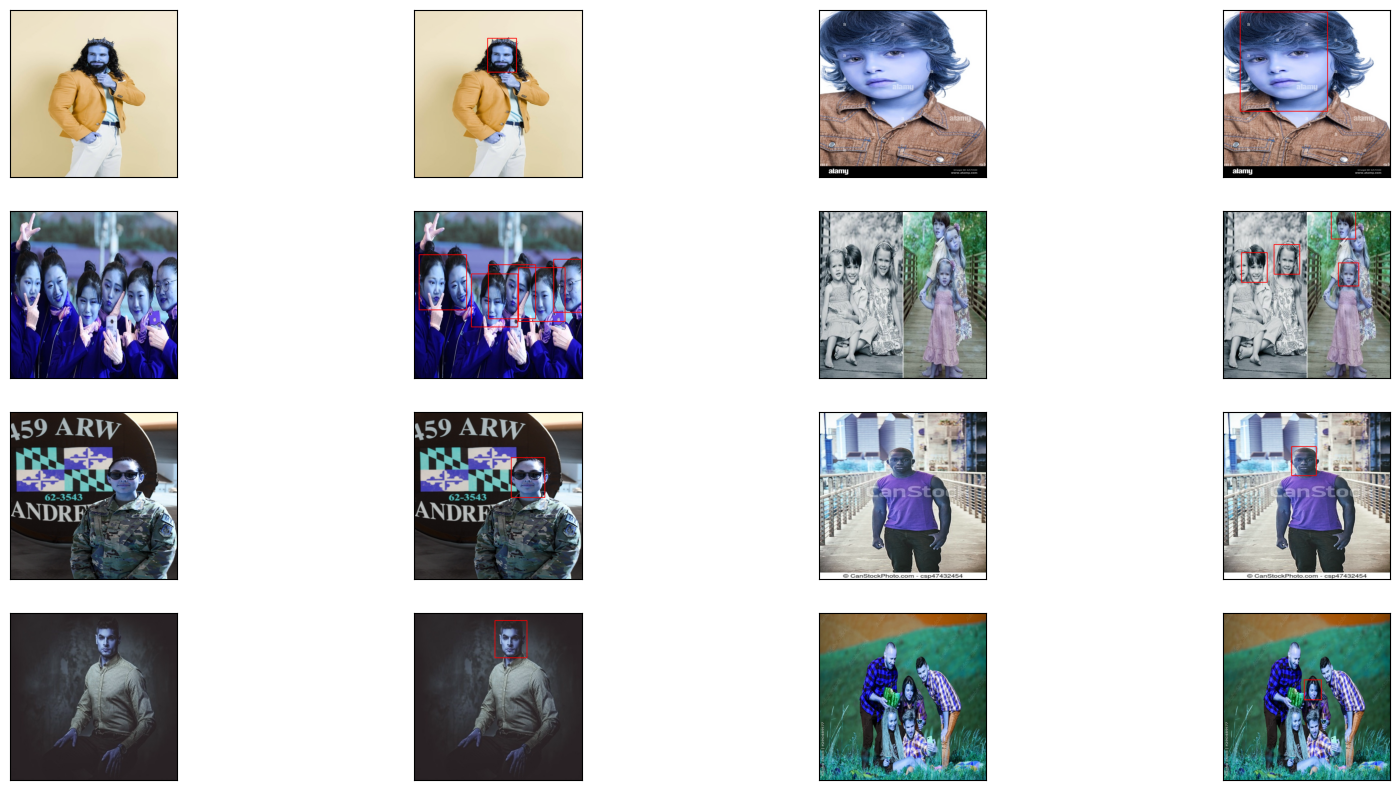

In [ ]:
plt.figure(figsize=(20,10))
for i in range(1,16,2):
    k=random.randint(0, len(imgtrain_list)-1)
    img_path=os.path.join(imgtrainpath, imgtrain_list[k])
    label_path=os.path.join(labeltrainpath, labeltrain_list[k])
    bbox=get_bbox_from_label(label_path)
    image=cv2.imread(img_path)
    image_copy=copy.deepcopy(image)
    ax=plt.subplot(4, 4, i)
    plt.imshow(image) # displaying image
    plt.xticks([])
    plt.yticks([])
    cv2.drawContours(image_copy, bbox, -1, red, 2) # drawing bounding box on copy of image
    ax=plt.subplot(4, 4, i+1)
    plt.imshow(image_copy) # displaying image with bounding box
    plt.xticks([])
    plt.yticks([])

##Training

Let's install ultralytics and use YOLOv8 to detect faces

In [ ]:
# Installing ultralytics
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 609.5/609.5 kB 5.0 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

In [ ]:
# Using YOLO's ptetrained model architecture and weights for training
model=YOLO('yolov8n.yaml').load('yolov8n.pt')


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [ ]:
# Training the model
results=model.train(data=config_path, epochs=100, resume=True, iou=0.5, conf=0.001)

Ultralytics YOLOv8.0.162 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/config.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=None, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=0.001, iou=0.5, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, d

In [ ]:
#!zip -r results.zip /content/drive/MyDrive/Colab Notebooks


mAP50 is the average precision value obtained by model at 50% IoU. This is the default metric used by YOLOv8 for object detection tasks.

Let's see how the training progressed with epochs by visualizing the plots

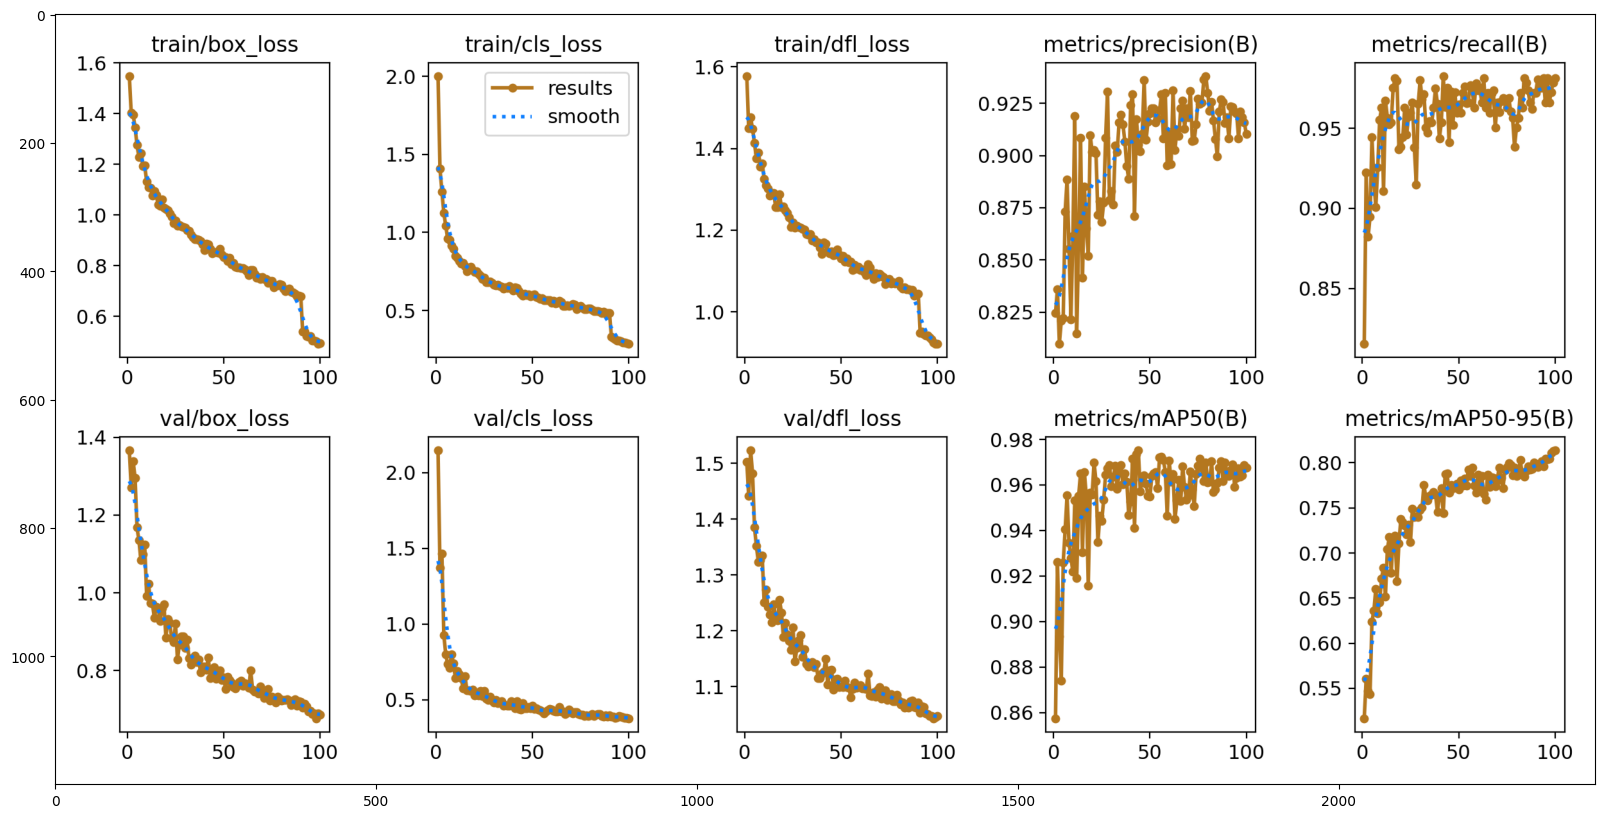

In [ ]:
plt.figure(figsize=(20,10))
trainingresult_path=os.path.join(curr_path, 'runs', 'detect', 'train')
results_png=cv2.imread(os.path.join(trainingresult_path,'results.png'))
plt.imshow(results_png)

All losses- Box loss, class loss, dfl loss are decreasing with epochs.
All metrics- Precision, Recall, mAP50 and mAP50-95 are increasing with epochs
Let's check the model performance on training, validation and test datasets

##Model Performance

In [ ]:
# function for evaluating model metrics map50
def evaluate_map50(trainedmodel, data_path, dataset='val'):
    metrics=trainedmodel.val(data=data_path, split=dataset)
    map50=round(metrics.box.map50, 3)
    print("The mAP of model on {0} dataset is {1}".format(dataset,map50))
    return metrics, map50

In [ ]:
# function for displaying plots created by YOLO
def display_curves(root_path):
    plt.figure(figsize=(30,30))

    #displaying p curve
    p_curve=cv2.imread(os.path.join(root_path,'P_curve.png'))
    ax=plt.subplot(5,1,1)
    plt.imshow(p_curve)

    #displaying r curve
    r_curve=cv2.imread(os.path.join(root_path,'R_curve.png'))
    ax=plt.subplot(5,1,2)
    plt.imshow(r_curve)

    #displaying pr curve
    pr_curve=cv2.imread(os.path.join(root_path,'PR_curve.png'))
    ax=plt.subplot(5,1,3)
    plt.imshow(pr_curve)

    #displaying f1 curve
    f1_curve=cv2.imread(os.path.join(root_path,'F1_curve.png'))
    ax=plt.subplot(5,1,4)
    plt.imshow(f1_curve)

    #displaying confusion matrix
    confusion_matrix=cv2.imread(os.path.join(root_path,'confusion_matrix.png'))
    ax=plt.subplot(5,1,5)
    plt.imshow(confusion_matrix)


In [ ]:
# Evaluating train metrics
train_metrics, train_map50=evaluate_map50(model, config_path, dataset='train')

Ultralytics YOLOv8.0.162 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients
val: Scanning /content/labels/train.cache... 1763 images, 6 backgrounds, 0 corrupt: 100%|██████████| 1769/1769 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:27<00:00,  4.02it/s]
                   all       1769       2686      0.964      0.991      0.988      0.908
Speed: 0.6ms preprocess, 4.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/val


The mAP of model on train dataset is 0.988


In [ ]:
train_path=os.path.join(curr_path, 'runs', 'detect', 'val') #val is a misnomer, it is actually measuring validation on training dataset

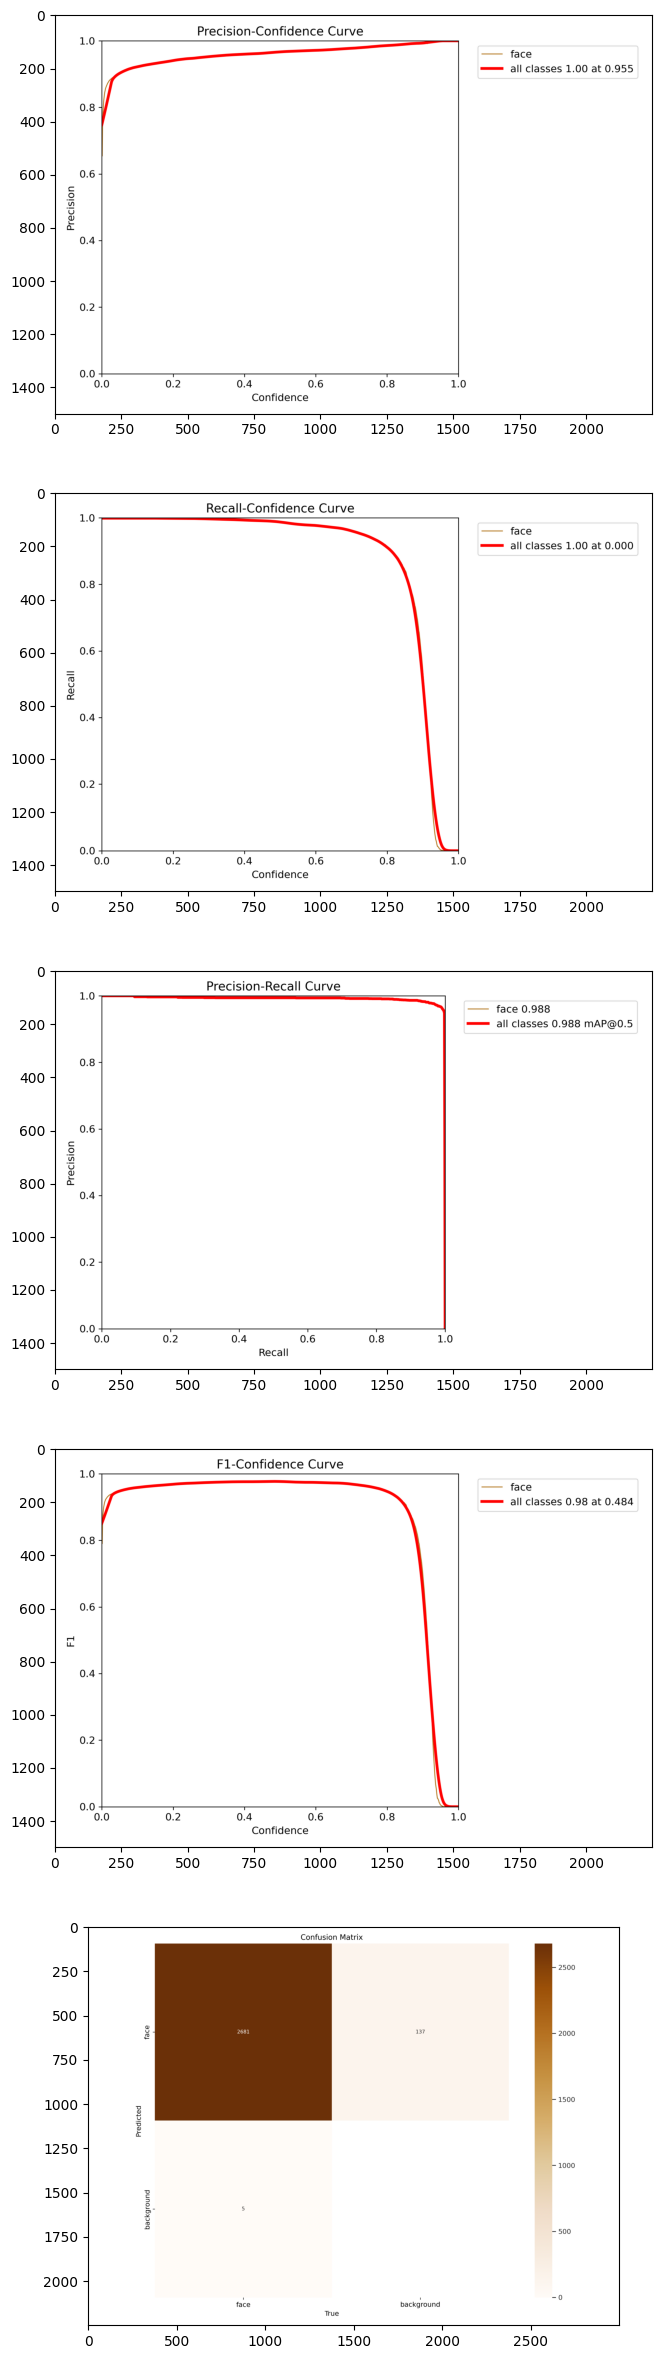

In [ ]:
# Display plots on training data
display_curves(train_path)

In [ ]:
# Evaluating val metrics
val_metrics, val_map50=evaluate_map50(model, config_path, dataset='val')

Ultralytics YOLOv8.0.162 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
val: Scanning /content/labels/validation.cache... 220 images, 1 backgrounds, 0 corrupt: 100%|██████████| 221/221 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.28it/s]
                   all        221        323       0.91      0.981      0.968      0.814
Speed: 1.4ms preprocess, 6.6ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val2


The mAP of model on val dataset is 0.968


In [ ]:
val_path=os.path.join(curr_path, 'runs', 'detect', 'val2')


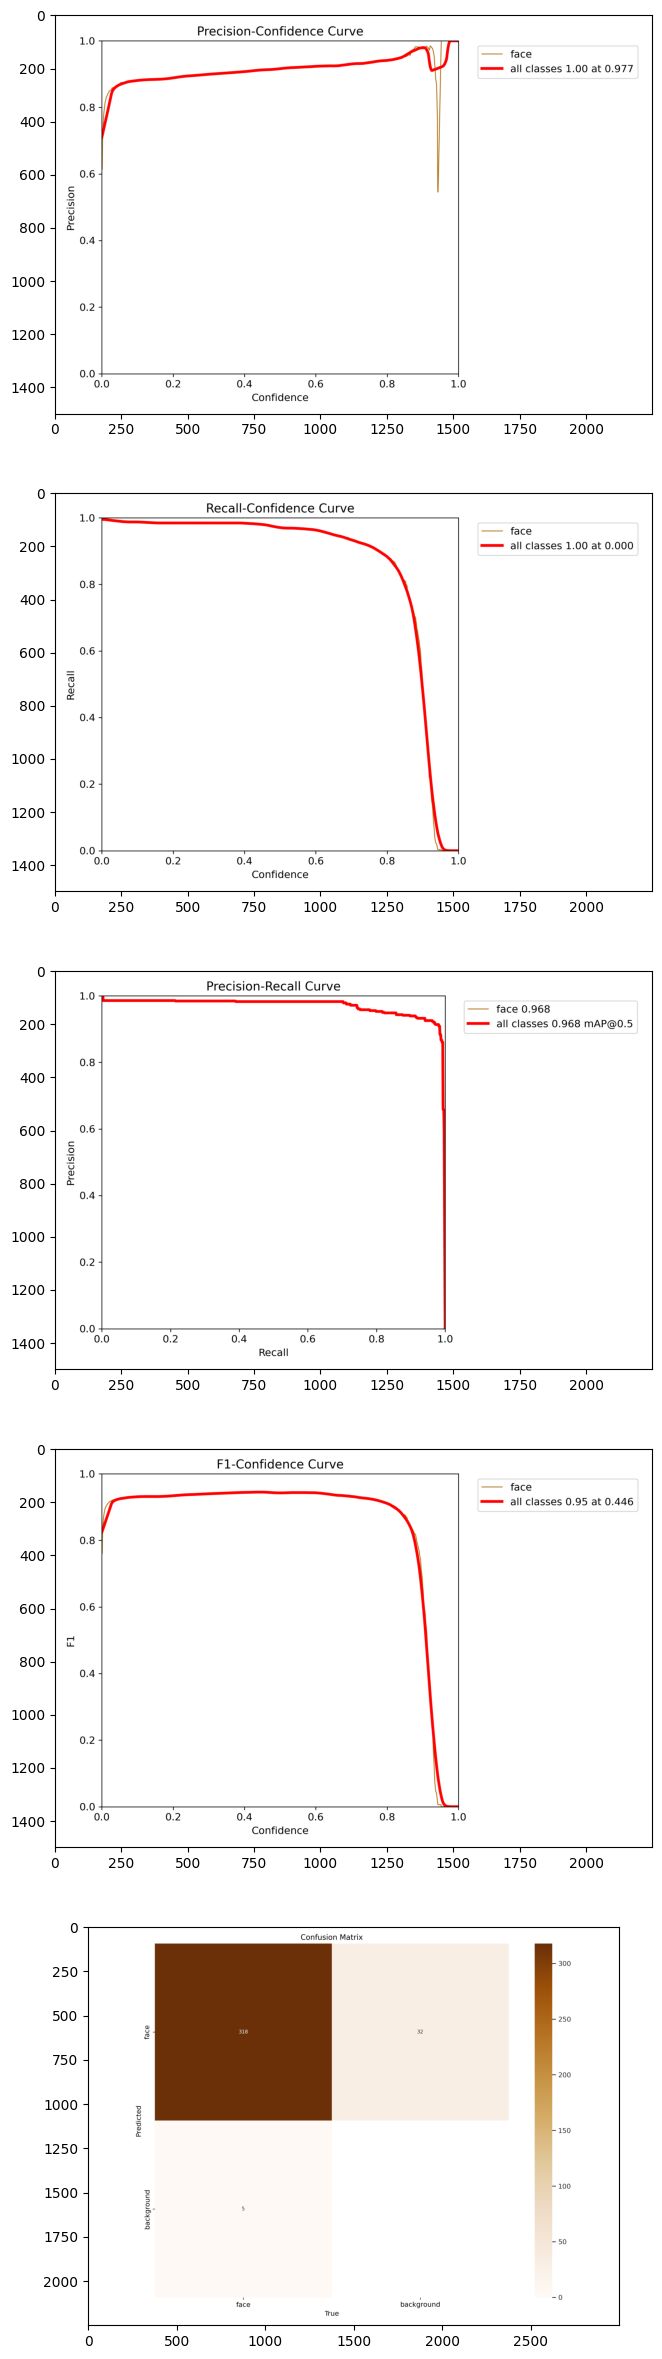

In [ ]:
# Display plots on validation data
display_curves(val_path)

In [ ]:
# Evaluating test metrics
test_metrics, test_map50=evaluate_map50(model, config_path, dataset='test')

Ultralytics YOLOv8.0.162 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
val: Scanning /content/labels/test... 221 images, 1 backgrounds, 0 corrupt: 100%|██████████| 222/222 [00:00<00:00, 356.39it/s]
val: New cache created: /content/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.29it/s]
                   all        222        341      0.908      0.927      0.972      0.829
Speed: 1.2ms preprocess, 5.5ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val3


The mAP of model on test dataset is 0.972


In [ ]:
test_path=os.path.join(curr_path, 'runs', 'detect', 'val3') #val3 is a misnomer, it is actually measuring validation on test dataset

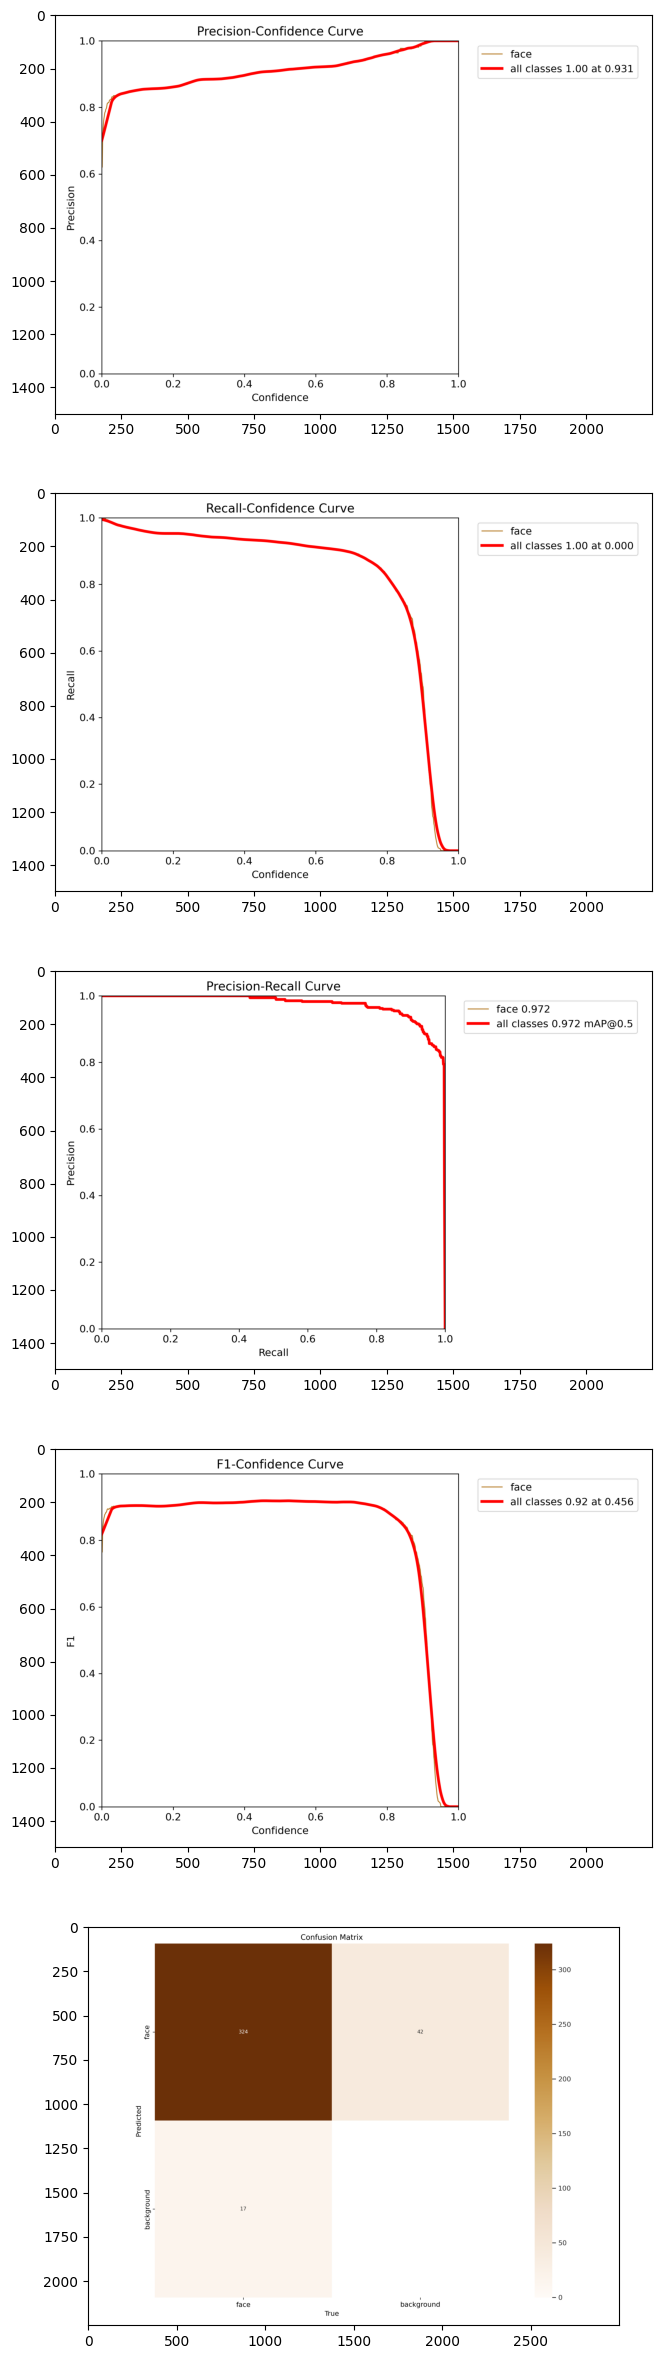

In [ ]:
# Display plots on test data
display_curves(test_path)

##Visualizing model's performance on random test images


image 1/1 /content/images/test/00001853.jpg: 640x640 2 faces, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/images/test/00000296.jpg: 640x640 1 face, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/images/test/00002753.jpg: 640x640 3 faces, 10.8ms
Speed: 3.7ms preprocess, 10.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/images/test/00002828.jpg: 640x640 1 face, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


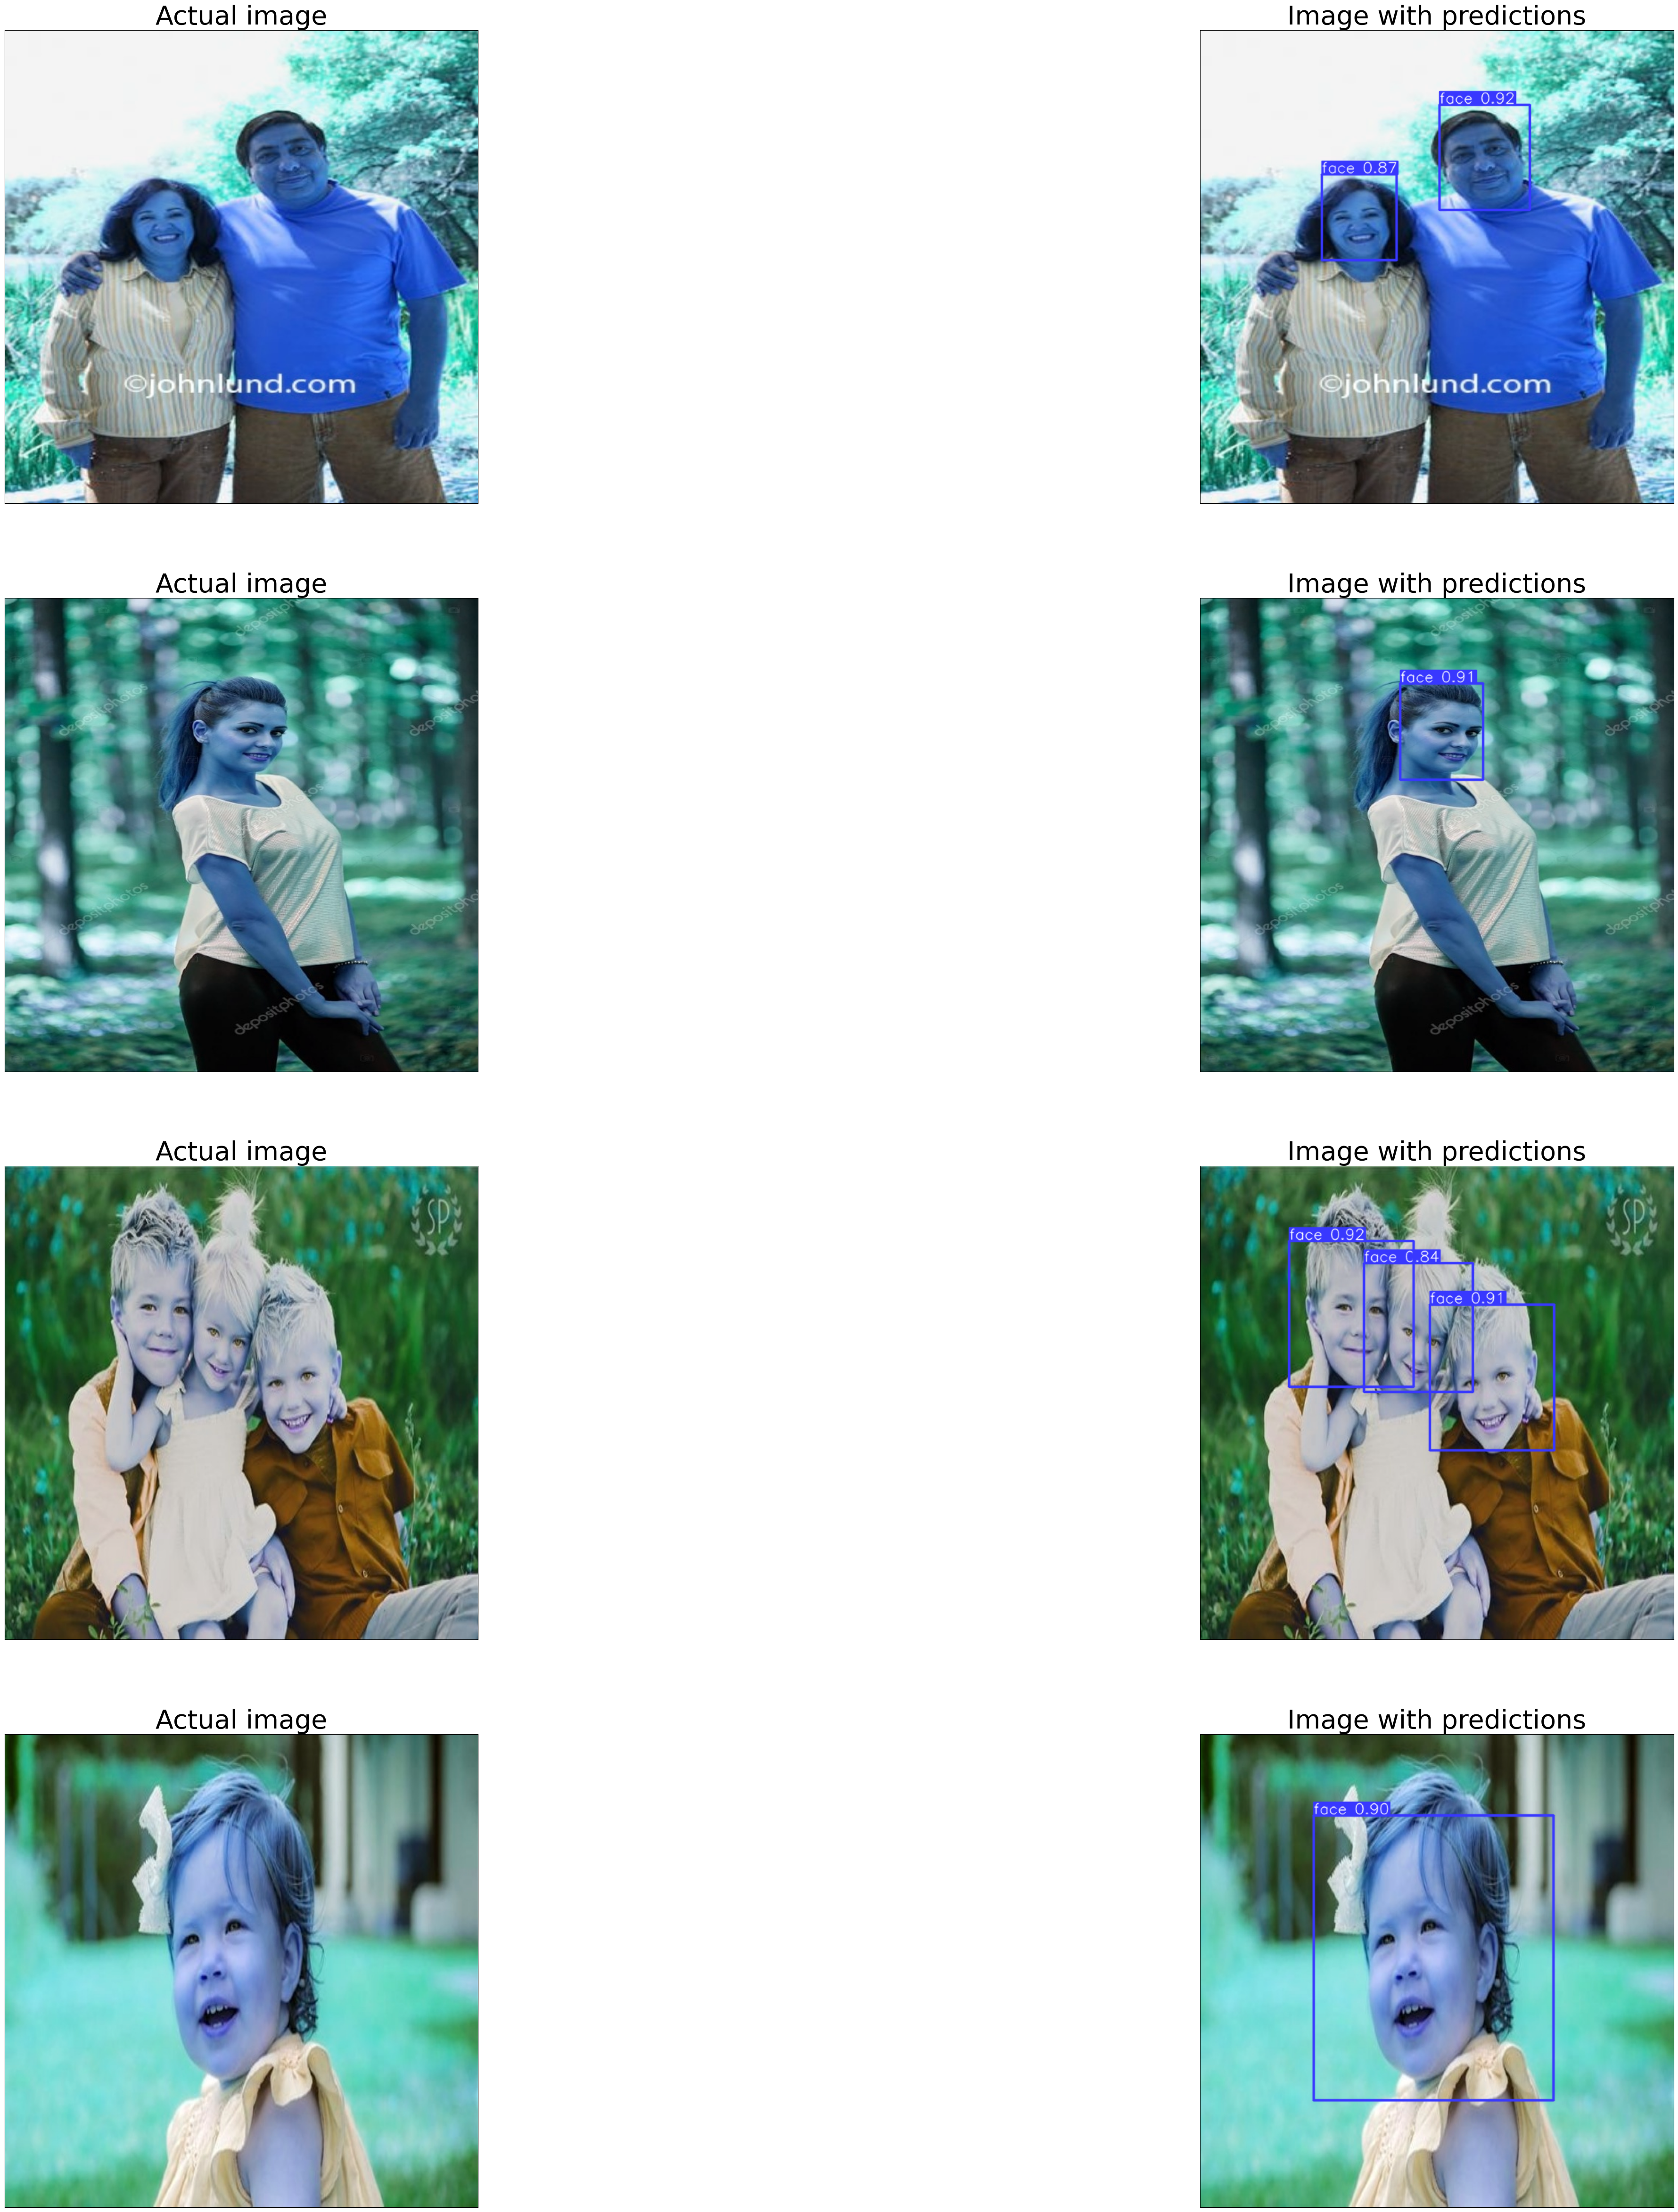

In [ ]:
plt.figure(figsize=(60,60))
m=random.randint(0, 150) # Selecting random image number
for i in range(1,8,2):
    test_image=os.path.join(imgtestpath, os.listdir(imgtestpath)[m])
    ax=plt.subplot(4,2,i)

    # Display actual image
    plt.imshow(cv2.imread(test_image))
    plt.xticks([])
    plt.yticks([])
    plt.title("Actual image", fontsize = 40)

    # Predict
    res = model(test_image)
    res_plotted = res[0].plot()
    ax=plt.subplot(4,2,i+1)

    # Display image with predictions
    plt.imshow(res_plotted)
    plt.title("Image with predictions", fontsize = 40)
    plt.xticks([])
    plt.yticks([])
    m=m+1